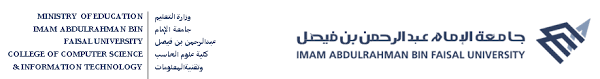

# Weather image recognition using deep learning techniques
Weather image recognition using deep learning is a crucial application for monitoring and forecasting climate change. This project improves the classification of weather type from images by utilizing advanced models such as convolutional neural networks, transfer learning and vision transformers. The accurate identification of weather phenomena is essential for environmental monitoring, agricultural planning, and enhancing vehicle assistant driving systems. The dataset used is from Kaggle website containing 6,862 images categorized into 11 weather types: dew, fog/smog, frost, glaze, hail, lightning, rain, rainbow, rime, sandstorm, and snow. We divided the dataset into 70% training, 15% validation and 15% testing sets. The pretrained vision transformers vit_b16 outperformed other models with 80% accuracy, 81% precision, 80% recall and 80% f1-score.

In [ ]:
!pip install vit-keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.8 MB/s eta 0:00:00


In [ ]:
# Importing needed libraries
from google.colab import drive
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
import os
import cv2
import warnings
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, EfficientNetB0
from vit_keras import vit

warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyunpack patool
import patoolib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 4.2 MB/s eta 0:00:00


In [ ]:
# Extract the .rar file
rar_file_path = '/content/drive/MyDrive/weatherImage.rar'
extract_to_path = '/content/weather_images'
patoolib.extract_archive(rar_file_path, outdir=extract_to_path)

INFO patool: Extracting /content/drive/MyDrive/weatherImage.rar ...
INFO:patool:Extracting /content/drive/MyDrive/weatherImage.rar ...
INFO patool: ... creating output directory `/content/weather_images'.
INFO:patool:... creating output directory `/content/weather_images'.
INFO patool: running /usr/bin/unrar x -- /content/drive/MyDrive/weatherImage.rar
INFO:patool:running /usr/bin/unrar x -- /content/drive/MyDrive/weatherImage.rar
INFO patool:     with cwd='/content/weather_images', input=''
INFO:patool:    with cwd='/content/weather_images', input=''
INFO patool: ... /content/drive/MyDrive/weatherImage.rar extracted to `/content/weather_images'.
INFO:patool:... /content/drive/MyDrive/weatherImage.rar extracted to `/content/weather_images'.


'/content/weather_images'

## Preprocessing
1. Split data into train, validation and testing sets
2. Image rescaling and normalization: The images are rescaled to the range [0-1] by dividing the pixels by 255.
3. Augmentation for the training set by rotation, width/height shift, shear, zoom, and horizontal flip.

In [ ]:
!pip install split-folders
import splitfolders

# Split the dataset into training (70%), validation (15%), and test (15%) sets
input_folder = '/content/weather_images/dataset'
output_folder = '/content/weather_images/split_dataset'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 6862 files [00:03, 1778.10 files/s]


In [ ]:
# Path to the split dataset
train_path = '/content/weather_images/split_dataset/train'
validation_path = '/content/weather_images/split_dataset/val'
test_path = '/content/weather_images/split_dataset/test'

In [ ]:
# Parameters
target_size = (128, 128)
batch_size = 32

# Image Data Generators with data augmentation for training and rescaling for validation and test
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Data Generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Data Generator
validation_generator = validation_datagen.flow_from_directory(
    validation_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Test Data Generator
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 4798 images belonging to 11 classes.
Found 1023 images belonging to 11 classes.
Found 1041 images belonging to 11 classes.


## Convolutional Neural Network (CNN)
In computer vision, CNN is a popular type of deep learning architectures for image recognition and classification tasks.

In [ ]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

Epoch 1/20
150/150 [==============================] - 48s 271ms/step - loss: 1.9492 - accuracy: 0.3347 - val_loss: 1.4654 - val_accuracy: 0.5269
Epoch 2/20
150/150 [==============================] - 41s 274ms/step - loss: 1.5117 - accuracy: 0.5010 - val_loss: 1.1324 - val_accuracy: 0.6217
Epoch 3/20
150/150 [==============================] - 40s 265ms/step - loss: 1.3714 - accuracy: 0.5377 - val_loss: 1.1375 - val_accuracy: 0.5943
Epoch 4/20
150/150 [==============================] - 38s 255ms/step - loss: 1.3172 - accuracy: 0.5517 - val_loss: 1.1215 - val_accuracy: 0.6227
Epoch 5/20
150/150 [==============================] - 40s 266ms/step - loss: 1.2585 - accuracy: 0.5744 - val_loss: 1.0444 - val_accuracy: 0.6315
Epoch 6/20
150/150 [==============================] - 42s 282ms/step - loss: 1.2137 - accuracy: 0.5934 - val_loss: 0.9670 - val_accuracy: 0.6618
Epoch 7/20
150/150 [==============================] - 40s 269ms/step - loss: 1.1954 - accuracy: 0.5986 - val_loss: 1.2143 - val_ac

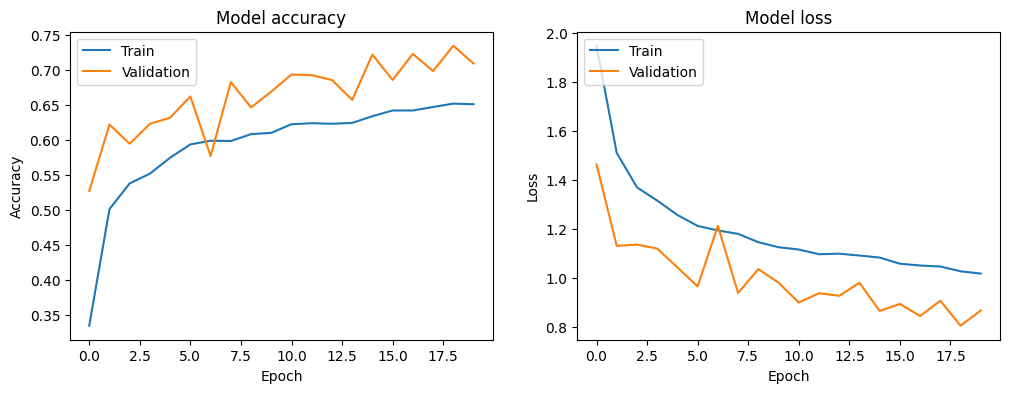

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

33/33 [==============================] - 3s 102ms/step - loss: 0.8874 - accuracy: 0.7012
Test Loss: 0.8873862624168396
Test Accuracy: 0.701248824596405
33/33 [==============================] - 8s 247ms/step
              precision    recall  f1-score   support

         dew       0.77      0.81      0.79       106
     fogsmog       0.82      0.87      0.84       129
       frost       0.44      0.58      0.50        72
       glaze       0.36      0.34      0.35        97
        hail       0.68      0.54      0.60        90
   lightning       0.89      0.83      0.86        58
        rain       0.70      0.61      0.65        80
     rainbow       0.76      0.72      0.74        36
        rime       0.76      0.85      0.80       174
   sandstorm       0.92      0.77      0.84       105
        snow       0.60      0.60      0.60        94

    accuracy                           0.70      1041
   macro avg       0.70      0.68      0.69      1041
weighted avg       0.71      0.70  

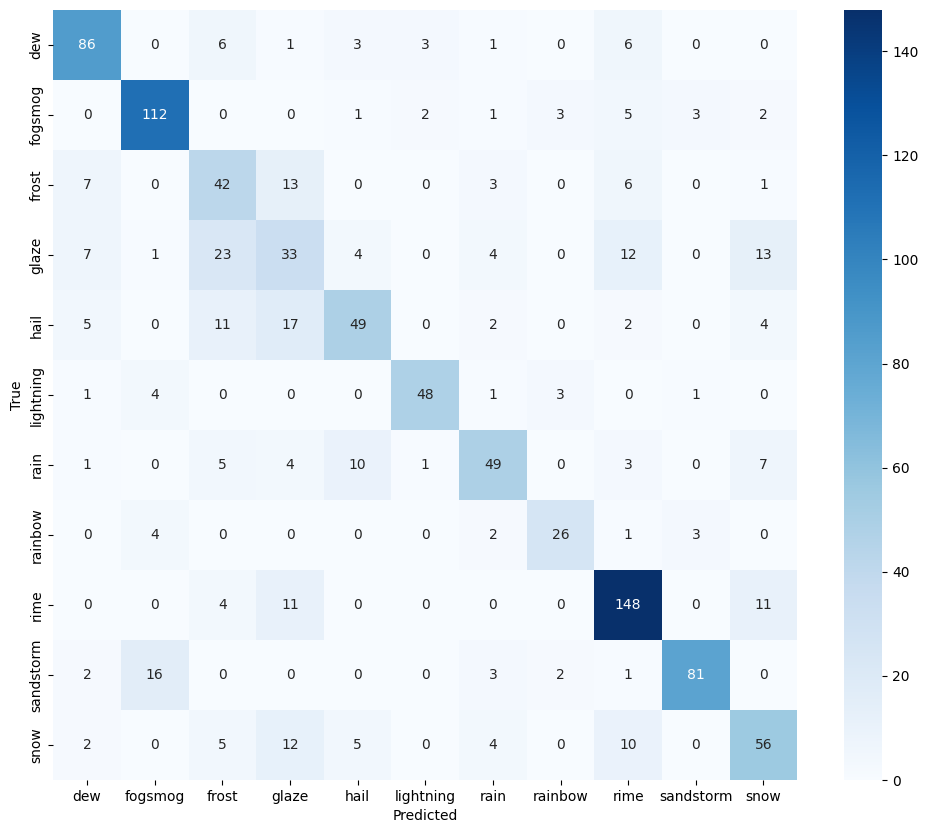

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Display a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Transfer learning
Using predefined and pretrained models to new tasks. The utilized models in our project are VGG16 and InceptionV3 with CNN architecture and vit_b16 using vision transformers.




In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

58889256/58889256 [==============================] - 4s 0us/step
Epoch 1/20
150/150 [==============================] - 51s 303ms/step - loss: 1.7270 - accuracy: 0.4004 - val_loss: 1.2865 - val_accuracy: 0.5718
Epoch 2/20
150/150 [==============================] - 44s 295ms/step - loss: 1.2660 - accuracy: 0.5663 - val_loss: 1.0779 - val_accuracy: 0.6266
Epoch 3/20
150/150 [==============================] - 42s 280ms/step - loss: 1.1086 - accuracy: 0.6271 - val_loss: 0.9762 - val_accuracy: 0.6716
Epoch 4/20
150/150 [==============================] - 42s 279ms/step - loss: 1.0423 - accuracy: 0.6467 - val_loss: 0.9008 - val_accuracy: 0.7175
Epoch 5/20
150/150 [==============================] - 42s 280ms/step - loss: 0.9855 - accuracy: 0.6551 - val_loss: 0.8616 - val_accuracy: 0.7009
Epoch 6/20
150/150 [==============================] - 42s 278ms/step - loss: 0.9340 - accuracy: 0.6794 - val_loss: 0.8425 - val_accuracy: 0.7019
Epoch 7/20
150/150 [==============================] - 42s 278ms/s

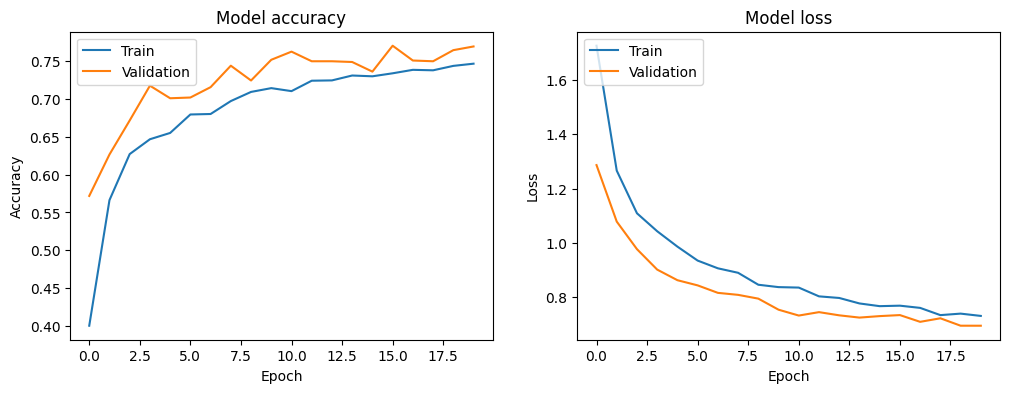

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

33/33 [==============================] - 7s 198ms/step - loss: 0.6714 - accuracy: 0.7944
Test Loss: 0.6713599562644958
Test Accuracy: 0.7944284081459045
33/33 [==============================] - 4s 106ms/step
              precision    recall  f1-score   support

         dew       0.90      0.80      0.85       106
     fogsmog       0.87      0.77      0.81       129
       frost       0.59      0.67      0.63        72
       glaze       0.63      0.62      0.62        97
        hail       0.84      0.86      0.85        90
   lightning       0.93      0.93      0.93        58
        rain       0.95      0.76      0.85        80
     rainbow       0.94      0.86      0.90        36
        rime       0.78      0.89      0.83       174
   sandstorm       0.73      0.82      0.77       105
        snow       0.76      0.76      0.76        94

    accuracy                           0.79      1041
   macro avg       0.81      0.79      0.80      1041
weighted avg       0.80      0.79 

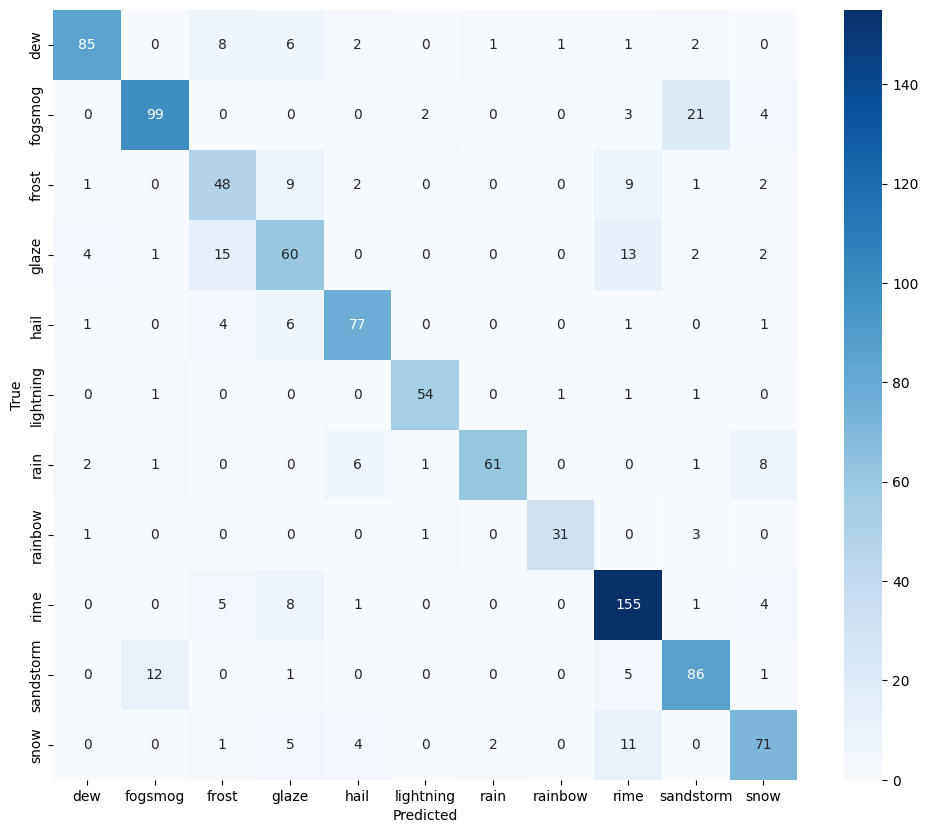

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Display a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator
)

87910968/87910968 [==============================] - 5s 0us/step
Epoch 1/20
150/150 [==============================] - 52s 301ms/step - loss: 1.8137 - accuracy: 0.4275 - val_loss: 1.1625 - val_accuracy: 0.6227
Epoch 2/20
150/150 [==============================] - 40s 263ms/step - loss: 1.3490 - accuracy: 0.5429 - val_loss: 1.0343 - val_accuracy: 0.6520
Epoch 3/20
150/150 [==============================] - 42s 278ms/step - loss: 1.2381 - accuracy: 0.5727 - val_loss: 1.0078 - val_accuracy: 0.6774
Epoch 4/20
150/150 [==============================] - 41s 275ms/step - loss: 1.1564 - accuracy: 0.6100 - val_loss: 0.9210 - val_accuracy: 0.6940
Epoch 5/20
150/150 [==============================] - 41s 274ms/step - loss: 1.1006 - accuracy: 0.6240 - val_loss: 0.8829 - val_accuracy: 0.6999
Epoch 6/20
150/150 [==============================] - 41s 274ms/step - loss: 1.1079 - accuracy: 0.6215 - val_loss: 0.8657 - val_accuracy: 0.7077
Epoch 7/20
150/150 [==============================] - 42s 280ms/s

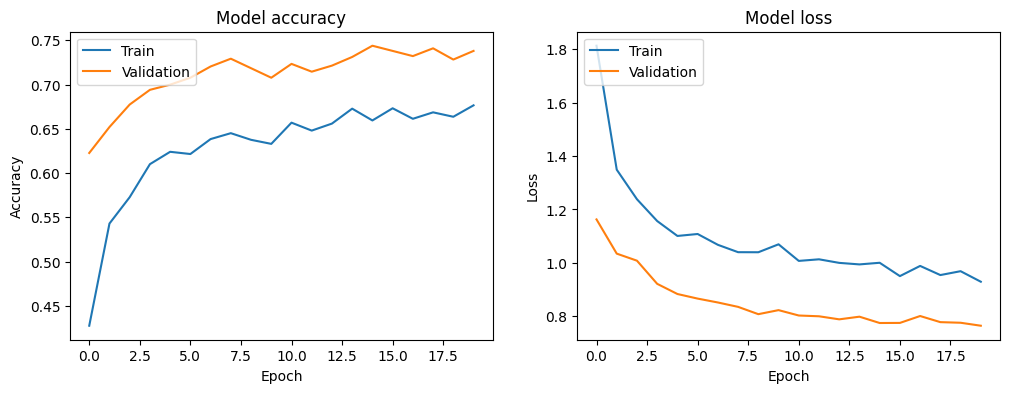

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

33/33 [==============================] - 6s 173ms/step - loss: 0.7500 - accuracy: 0.7435
Test Loss: 0.7500353455543518
Test Accuracy: 0.7435158491134644
33/33 [==============================] - 5s 100ms/step
              precision    recall  f1-score   support

         dew       0.83      0.86      0.84       106
     fogsmog       0.75      0.82      0.79       129
       frost       0.59      0.67      0.63        72
       glaze       0.66      0.38      0.48        97
        hail       0.86      0.80      0.83        90
   lightning       0.91      0.90      0.90        58
        rain       0.81      0.79      0.80        80
     rainbow       0.94      0.89      0.91        36
        rime       0.65      0.91      0.76       174
   sandstorm       0.80      0.64      0.71       105
        snow       0.67      0.50      0.57        94

    accuracy                           0.74      1041
   macro avg       0.77      0.74      0.75      1041
weighted avg       0.75      0.74 

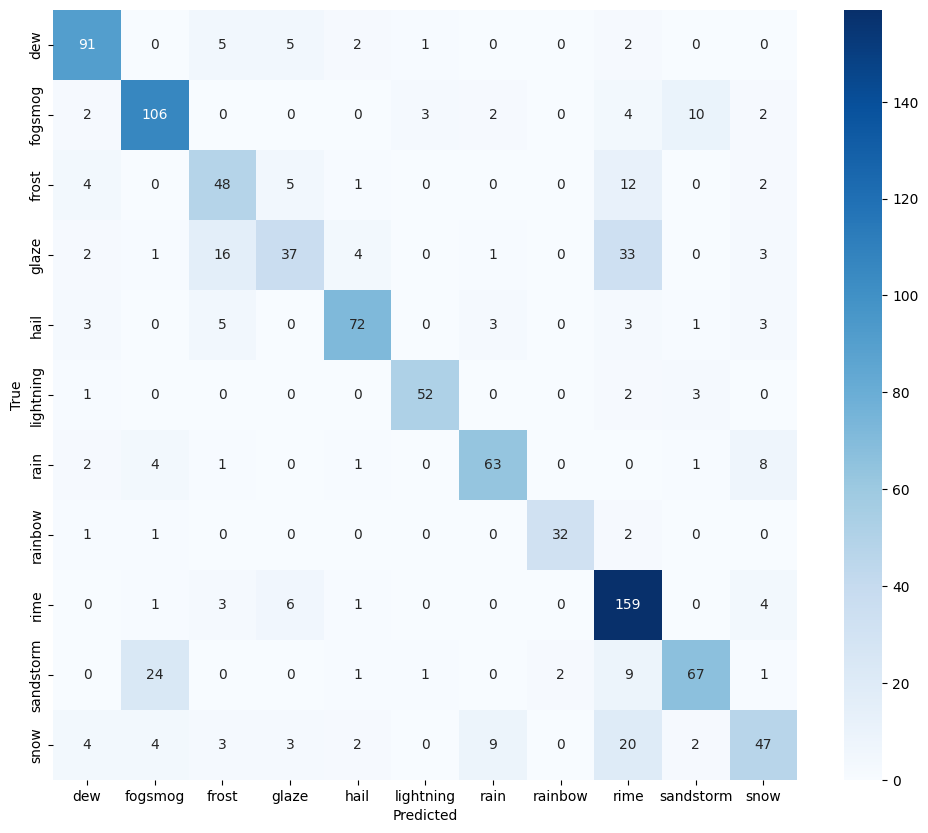

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Display a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
!pip install vit-keras

In [ ]:
!pip install tensorflow-addons

In [ ]:
# Define the input shape
input_shape = (128, 128, 3)

# Load the pre-trained Vision Transformer model
vit_model = vit.vit_b16(
    image_size=128,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

# Freeze the base model
vit_model.trainable = False

# Define the functional model
input_layer = Input(shape=input_shape)
x = vit_model(input_layer)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

347502902/347502902 [==============================] - 3s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85697280  
                                                                 
 dense_11 (Dense)            (None, 128)               98432     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 11)                1419      
                                                                 
Total params: 85797131 (327.29 MB)
Trainable params: 99851 (390.04 KB)
Non-trainable params: 85697280 (326.91 MB)
__________

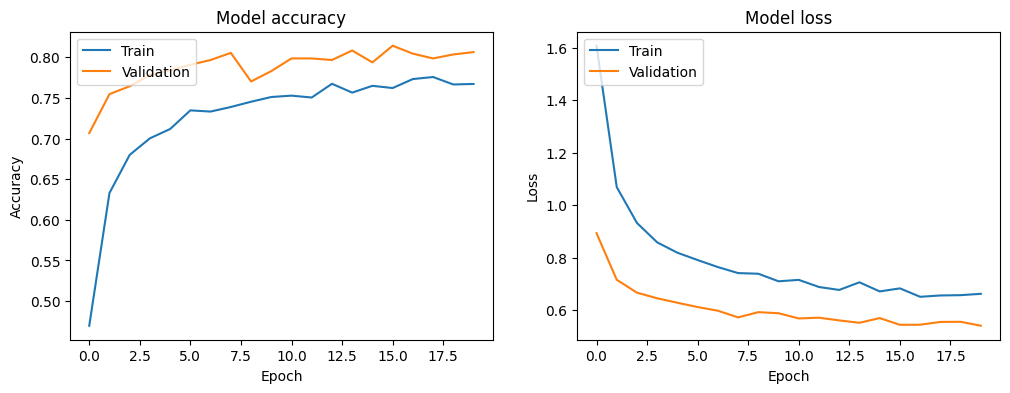

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

33/33 [==============================] - 6s 161ms/step - loss: 0.5600 - accuracy: 0.8012
Test Loss: 0.5600271821022034
Test Accuracy: 0.801152765750885
33/33 [==============================] - 9s 155ms/step
              precision    recall  f1-score   support

         dew       0.81      0.90      0.85       106
     fogsmog       0.83      0.88      0.86       129
       frost       0.72      0.54      0.62        72
       glaze       0.68      0.47      0.56        97
        hail       0.83      0.89      0.86        90
   lightning       0.95      1.00      0.97        58
        rain       0.79      0.82      0.80        80
     rainbow       0.94      0.94      0.94        36
        rime       0.72      0.89      0.80       174
   sandstorm       0.92      0.87      0.89       105
        snow       0.75      0.60      0.66        94

    accuracy                           0.80      1041
   macro avg       0.81      0.80      0.80      1041
weighted avg       0.80      0.80  

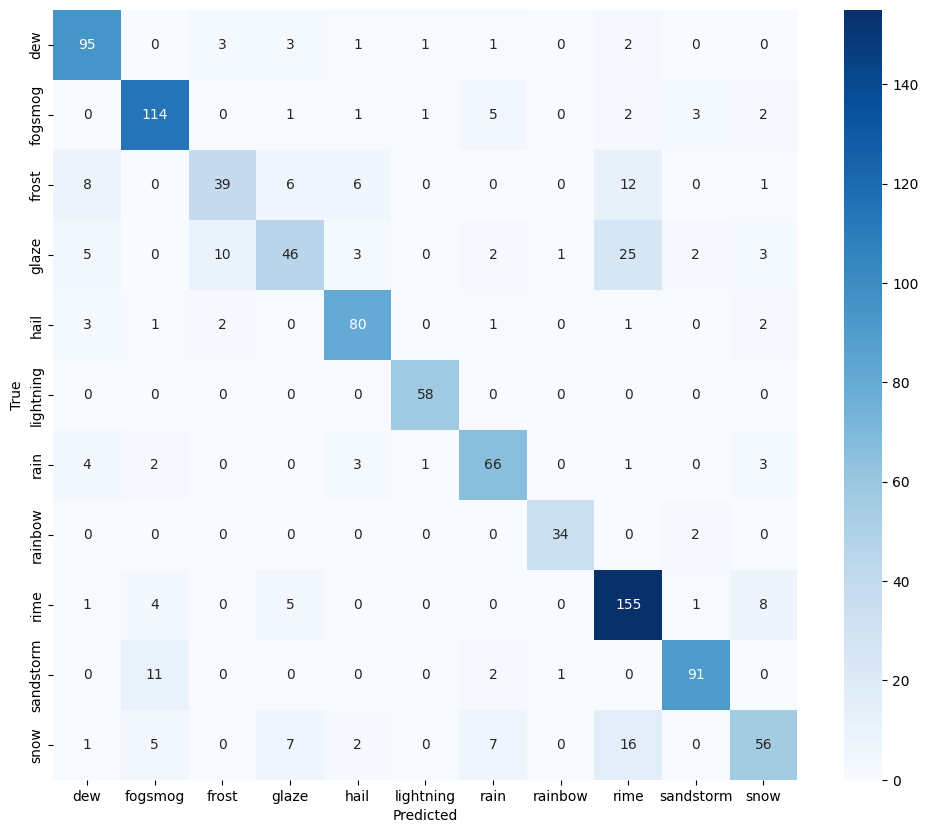

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Get predictions
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# True labels
true_classes = test_generator.classes

# Class labels
class_labels = list(test_generator.class_indices.keys())

# Display a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Conclusion & Future works


The project showcased the effectiveness of deep learning models, specifically CNNs and vision transformers, in accurately classifying weather images, with the best-performing model, Vision Transformer, achieving 80% accuracy, 81% precision, 80% recall, and 80% F1-score.
This project highlights the potential of AI in real-world challenges, such as weather classification, agriculture resource management, and road safety through advanced driver assistance systems.


In the future, a variety of areas can be investigated to enhance the functionality and performance of the weather image identification system:

1-Integration of Explainable AI (XAI)

2-Expansion of Dataset

3-Real-time Deployment

